In [1]:
import gcamreader
import os.path
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
regions = ['India', 'South Asia', 'China', 'Pakistan', 'Brazil','Africa_Western']
scenarios = ['GCAM_SSP4', 'GCAM_SSP5', 'GCAM_SSP1', 'GCAM_SSP2', 'GCAM_SSP3']

In [3]:
dbpath = "/Users/pramish/Desktop/Codes/netzero/gcam-v6.0/output"
dbfile = "database_basexdb"
conn = gcamreader.LocalDBConn(dbpath, dbfile)

Database scenarios: GCAM_SSP4, GCAM_SSP5, GCAM_SSP1, GCAM_SSP2, GCAM_SSP3


In [13]:
queries = gcamreader.parse_batch_query(os.path.join("../../", 'data', 'sample-queries.xml'))

In [14]:
[q.title for q in queries]

['primary energy consumption by region (direct equivalent)',
 'primary energy consumption by region (avg fossil efficiency)',
 'CO2 emissions by sector',
 'CO2 emissions by subsector',
 'CO2 prices',
 'total final energy by sector',
 'total final energy by region']

In [17]:
idx = 5
res = conn.runQuery(queries[idx], scenarios=scenarios, regions=regions)


In [18]:
res

Units                                  scenario          region  \
0        EJ  GCAM_SSP1,date=2022-3-12T21:43:44+06:015  Africa_Western   
1        EJ  GCAM_SSP1,date=2022-3-12T21:43:44+06:015  Africa_Western   
2        EJ  GCAM_SSP1,date=2022-3-12T21:43:44+06:015  Africa_Western   
3        EJ  GCAM_SSP1,date=2022-3-12T21:43:44+06:015  Africa_Western   
4        EJ  GCAM_SSP1,date=2022-3-12T21:43:44+06:015  Africa_Western   
...     ...                                       ...             ...   
23115    EJ   GCAM_SSP5,date=2022-3-12T19:47:47+05:45      South Asia   
23116    EJ   GCAM_SSP5,date=2022-3-12T19:47:47+05:45      South Asia   
23117    EJ   GCAM_SSP5,date=2022-3-12T19:47:47+05:45      South Asia   
23118    EJ   GCAM_SSP5,date=2022-3-12T19:47:47+05:45      South Asia   
23119    EJ   GCAM_SSP5,date=2022-3-12T19:47:47+05:45      South Asia   

                  sector  Year     value  
0           N fertilizer  1975  0.000578  
1           N fertilizer  1990  0.011747  
2           N fertilizer  2005  0.002278  
3           N fertilizer  2010  0.004114  
4           N fertilizer  2015  0.006228  
...                  ...   ...       ...  
23115  trn_shipping_intl  2080  0.225098  
23116  trn_shipping_intl  2085  0.238329  
23117  trn_shipping_intl  2090  0.251270  
23118  trn_shipping_intl  2095  0.263913  
23119  trn_shipping_intl  2100  0.276600  

[23120 rows x 6 columns]

In [8]:
category_column = 'sector' # fuel

In [9]:
### merge pakistan value into south asia
result = res.copy()

sa = result[result['region'] == 'South Asia']
pak = result[result['region'] == 'Pakistan']
sa_pak = pd.merge(sa, pak, on=['Year', category_column, 'scenario', 'Units'] ,how='left')
sa_pak['value'] = sa_pak['value_x'] + sa_pak['value_y']
sa_pak.rename(columns = {'region_x':'region'}, inplace = True)
sa_pak.drop(columns=['value_x', 'value_y'], inplace=True)

# Pakistan from result
# result = result[result['region'] != 'South Asia']
result = result[result['region'] != 'Pakistan']

# merge with original result
result = pd.merge(result, sa_pak, on=['Year', category_column, 'scenario', 'Units', 'region'], how='left')
result.rename(columns = {'value_x':'value'}, inplace = True)

# replace SA value
sa_mask = result['value_y'].isna().__invert__()
result.loc[sa_mask, 'value'] = result[sa_mask]['value_y']
result.drop(columns=['region_y', 'value_y'], inplace=True)
result

Units                                  scenario          region  \
0        EJ  GCAM_SSP1,date=2022-3-12T21:43:44+06:015  Africa_Western   
1        EJ  GCAM_SSP1,date=2022-3-12T21:43:44+06:015  Africa_Western   
2        EJ  GCAM_SSP1,date=2022-3-12T21:43:44+06:015  Africa_Western   
3        EJ  GCAM_SSP1,date=2022-3-12T21:43:44+06:015  Africa_Western   
4        EJ  GCAM_SSP1,date=2022-3-12T21:43:44+06:015  Africa_Western   
...     ...                                       ...             ...   
19550    EJ   GCAM_SSP5,date=2022-3-12T19:47:47+05:45      South Asia   
19551    EJ   GCAM_SSP5,date=2022-3-12T19:47:47+05:45      South Asia   
19552    EJ   GCAM_SSP5,date=2022-3-12T19:47:47+05:45      South Asia   
19553    EJ   GCAM_SSP5,date=2022-3-12T19:47:47+05:45      South Asia   
19554    EJ   GCAM_SSP5,date=2022-3-12T19:47:47+05:45      South Asia   

                  sector  Year     value  
0           N fertilizer  1975  0.000578  
1           N fertilizer  1990  0.011747  
2           N fertilizer  2005  0.002278  
3           N fertilizer  2010  0.004114  
4           N fertilizer  2015  0.006228  
...                  ...   ...       ...  
19550  trn_shipping_intl  2080  0.267109  
19551  trn_shipping_intl  2085  0.282994  
19552  trn_shipping_intl  2090  0.298536  
19553  trn_shipping_intl  2095  0.313741  
19554  trn_shipping_intl  2100  0.328971  

[19555 rows x 6 columns]

In [10]:
pd.unique(result['region'])

array(['Africa_Western', 'Brazil', 'China', 'India', 'South Asia'],
      dtype=object)

In [11]:
def plot_region(df, scenario, region, category_col, ax, x_col='Year', y_col='value'):

    # get data for only that region
    df = df[df['region'] == region]
    df = df[df['scenario'] == scenario]
    categories = pd.unique(df[category_col])

    # give subplot a title
    ax.title.set_text(region + f" {scenario}")
    # for each category draw a line chart of different color
    with plt.style.context('Solarize_Light2'):
        for cat in categories:
            sub_df = df[df[category_col] == cat]
            # plot data
            ax.plot(sub_df[x_col], sub_df[y_col], label=cat)
        ax.set_xlabel('Year')
        ax.set_ylabel('EJ')

    ax.legend(loc='upper right', bbox_to_anchor=(1.5,1))


def plot_query(df, scenario, category_col, x_col="Year", y_col="value", rows=5, cols=1, region_idx=None):
    regions = pd.unique(df['region'])
    if region_idx is None:
        # subplots for each region
        fig, subplots = plt.subplots(rows, cols, figsize=(1*10,6*10))
        for i in range(rows):
            for j in range(cols):
                if cols != 1:
                    subplot = subplots[i][j]
                else:
                    subplot = subplots[i]

                region_idx = i * cols + j
                region = regions[region_idx]
                plot_region(df, scenario, region, category_col, subplot)
    else:
        fig = plt.figure(figsize=(10,10))
        ax = plt.subplot(111)
        # plot for single region
        region = regions[region_idx]

        plot_region(df, scenario, region, category_col, ax)

    # adjust margins
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

    plt.show()


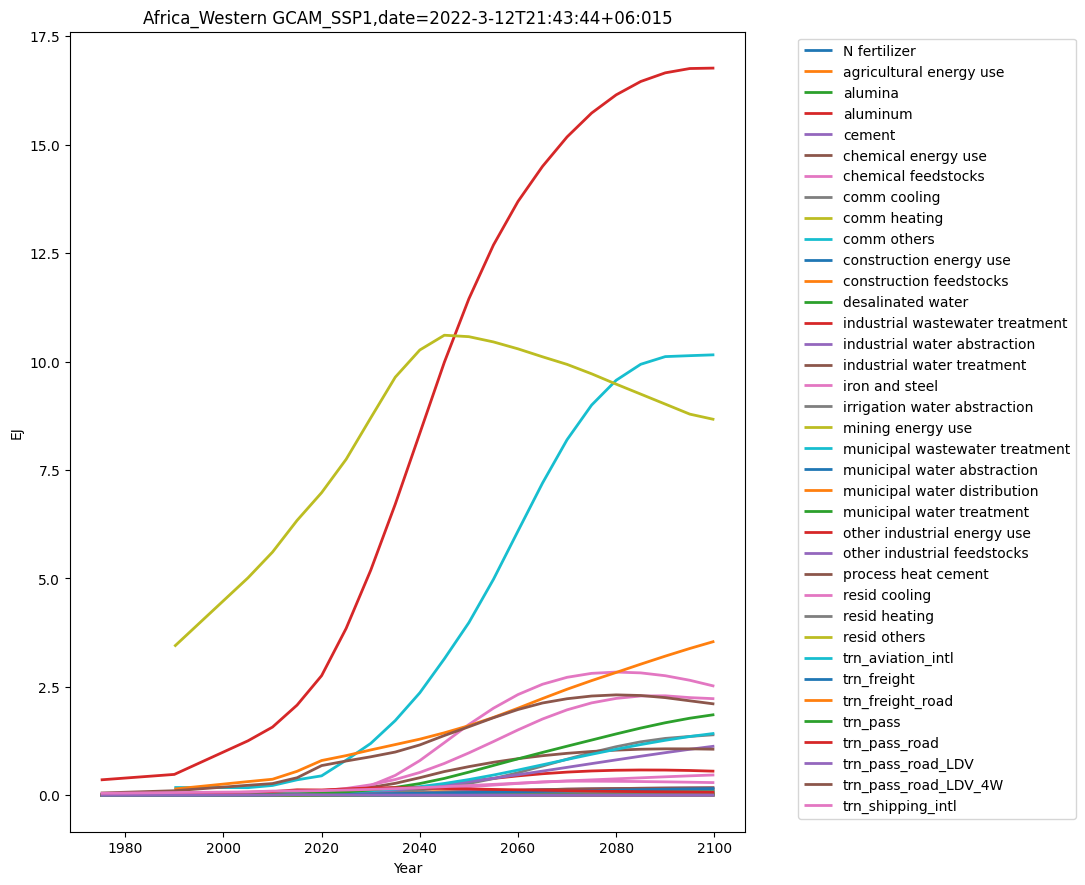

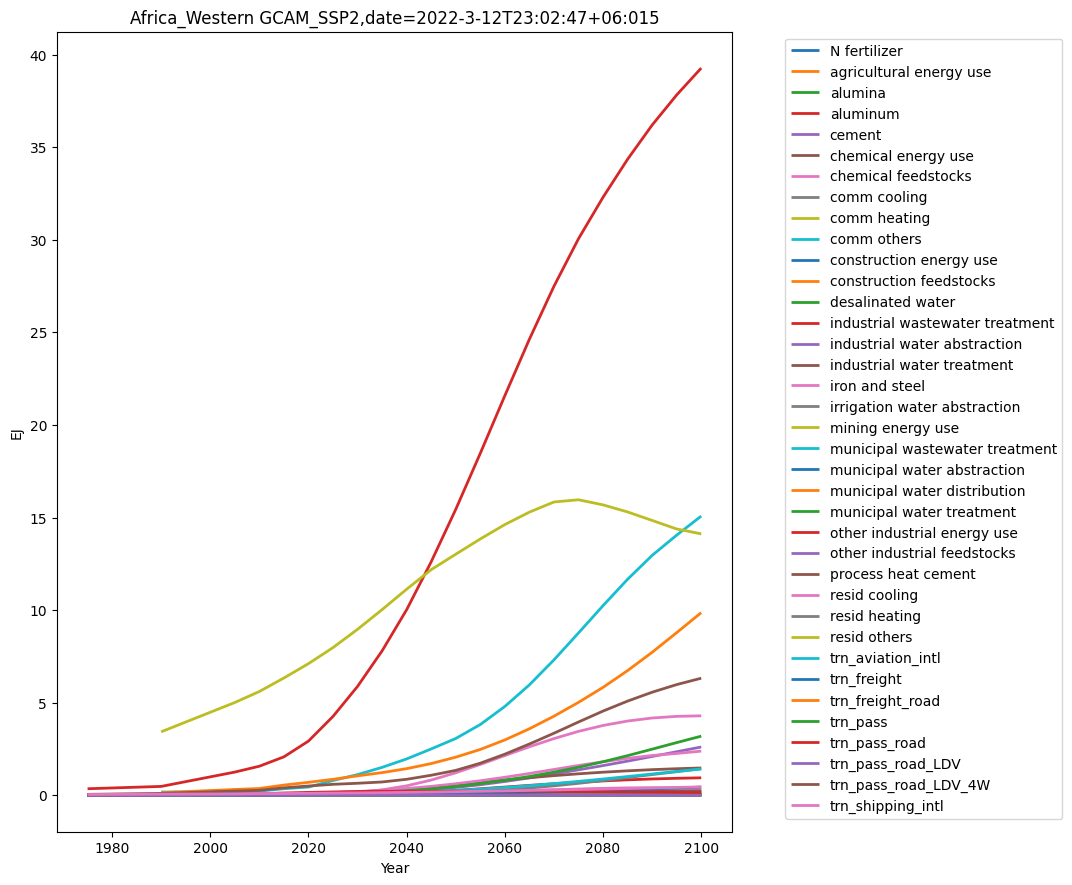

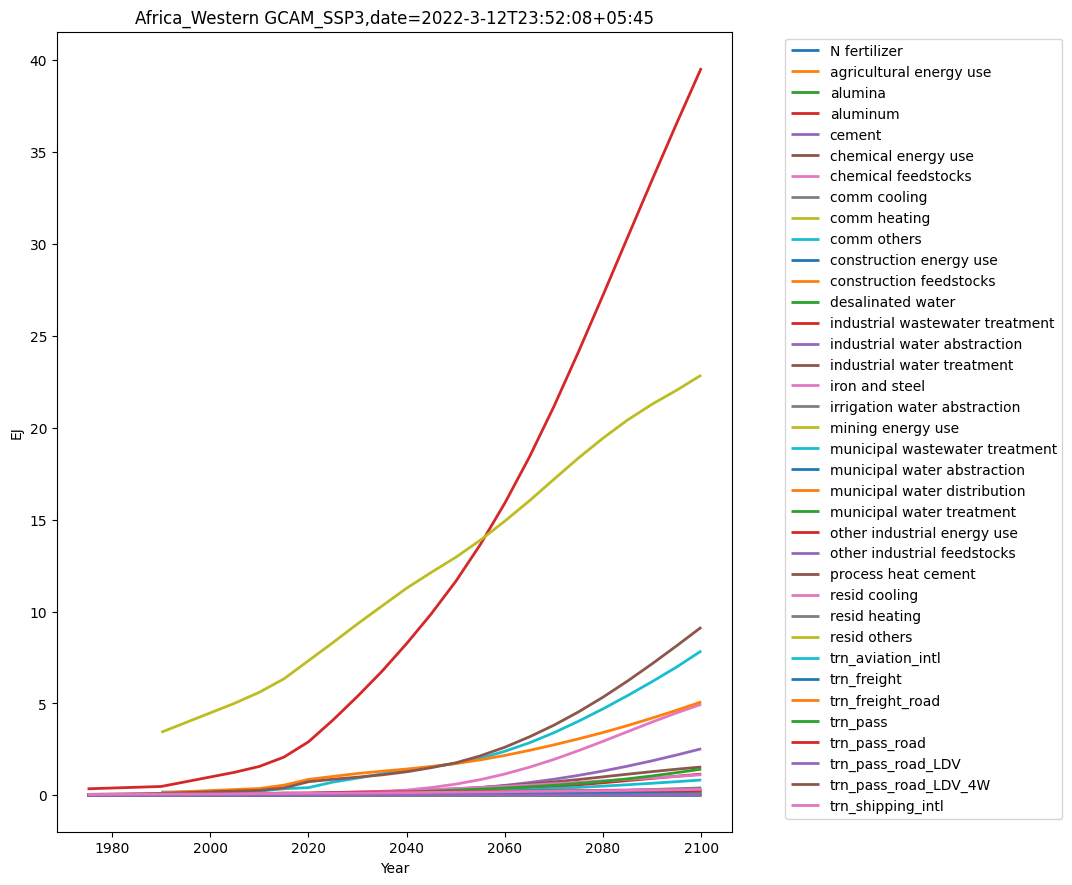

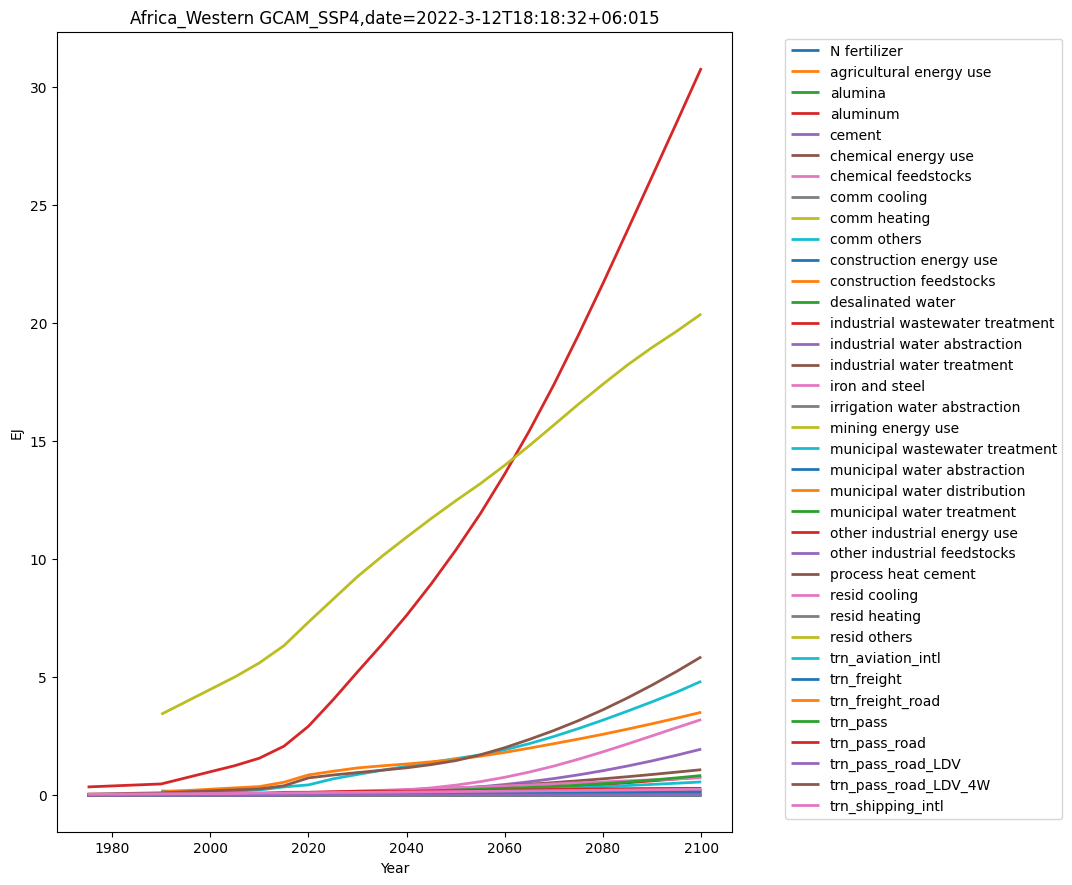

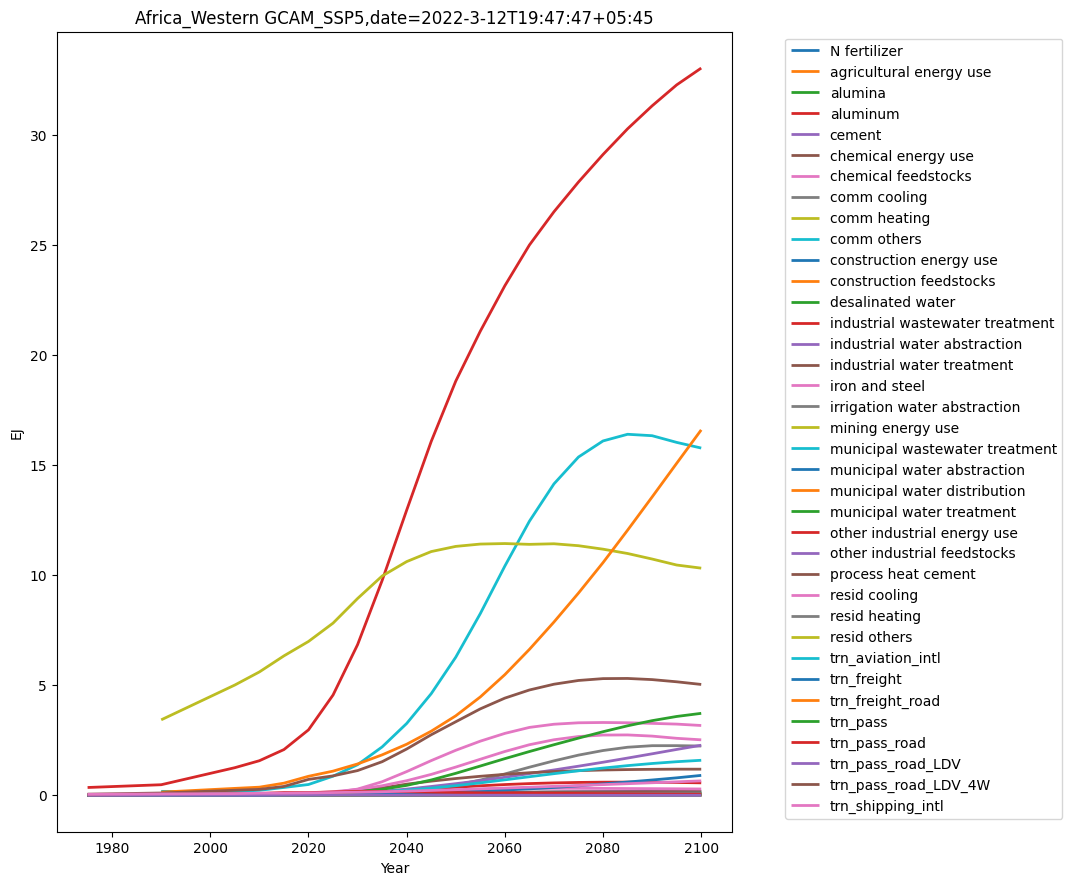

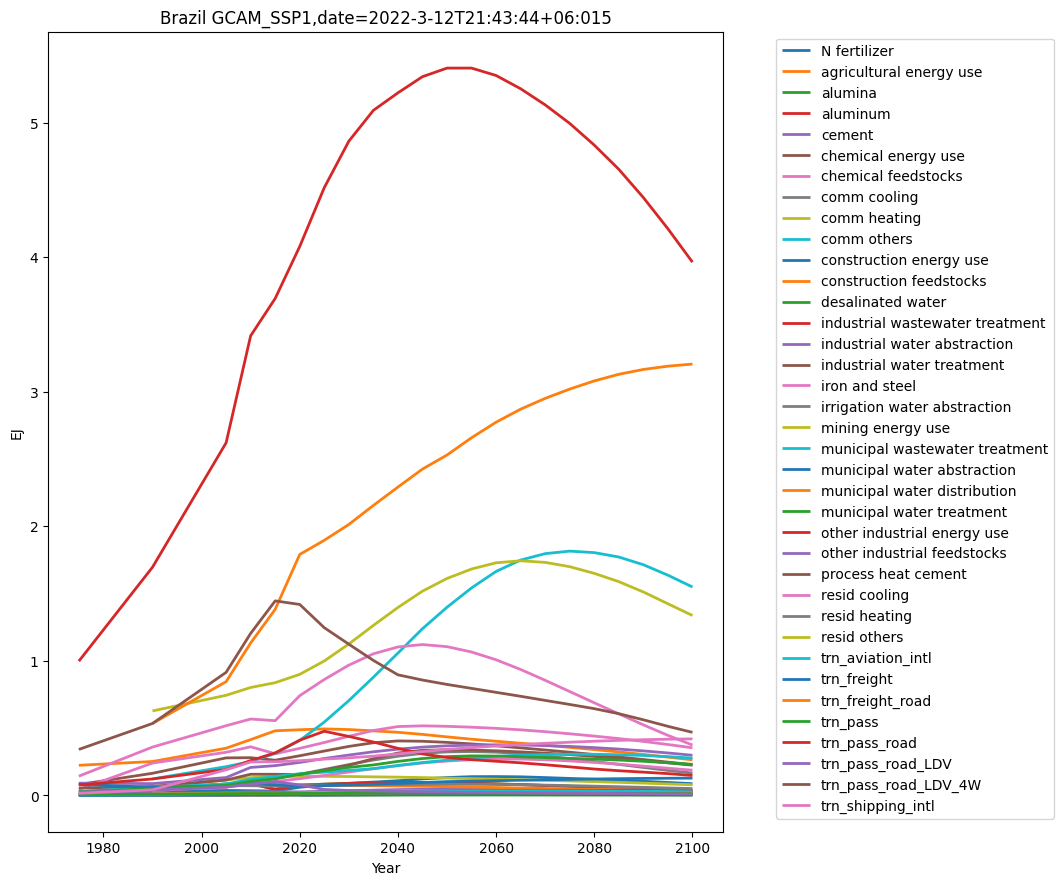

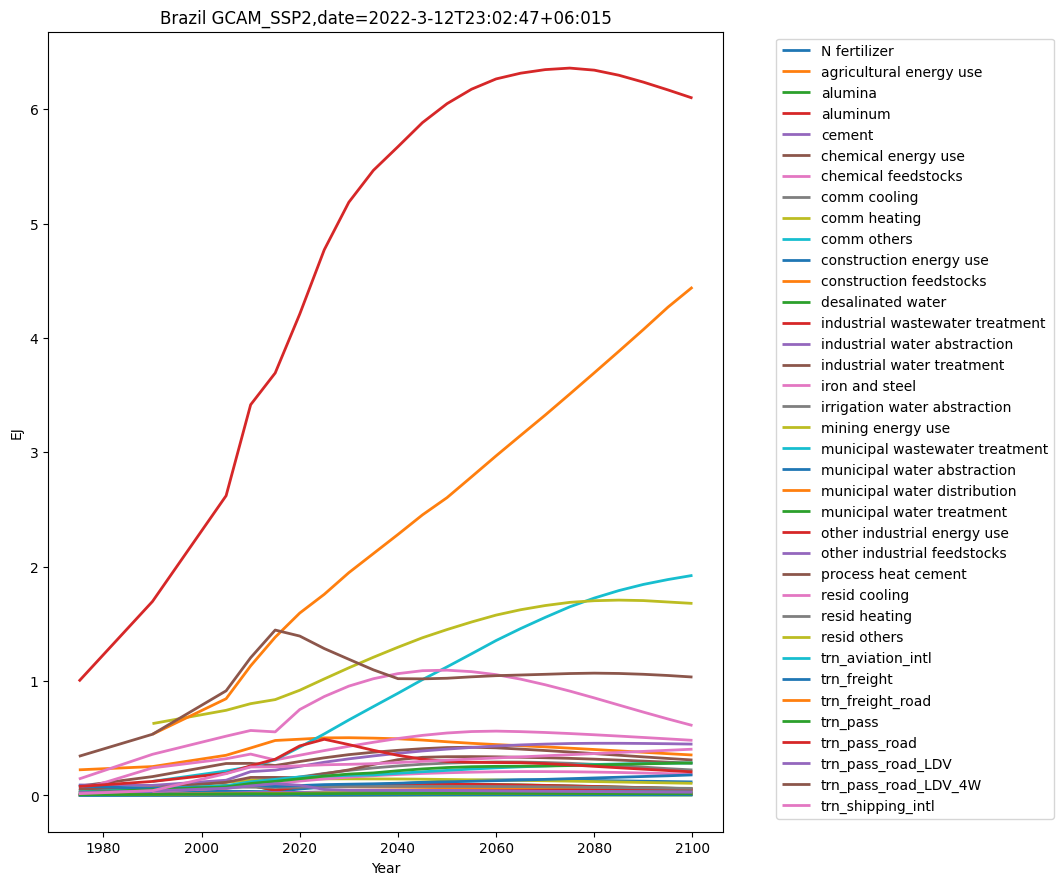

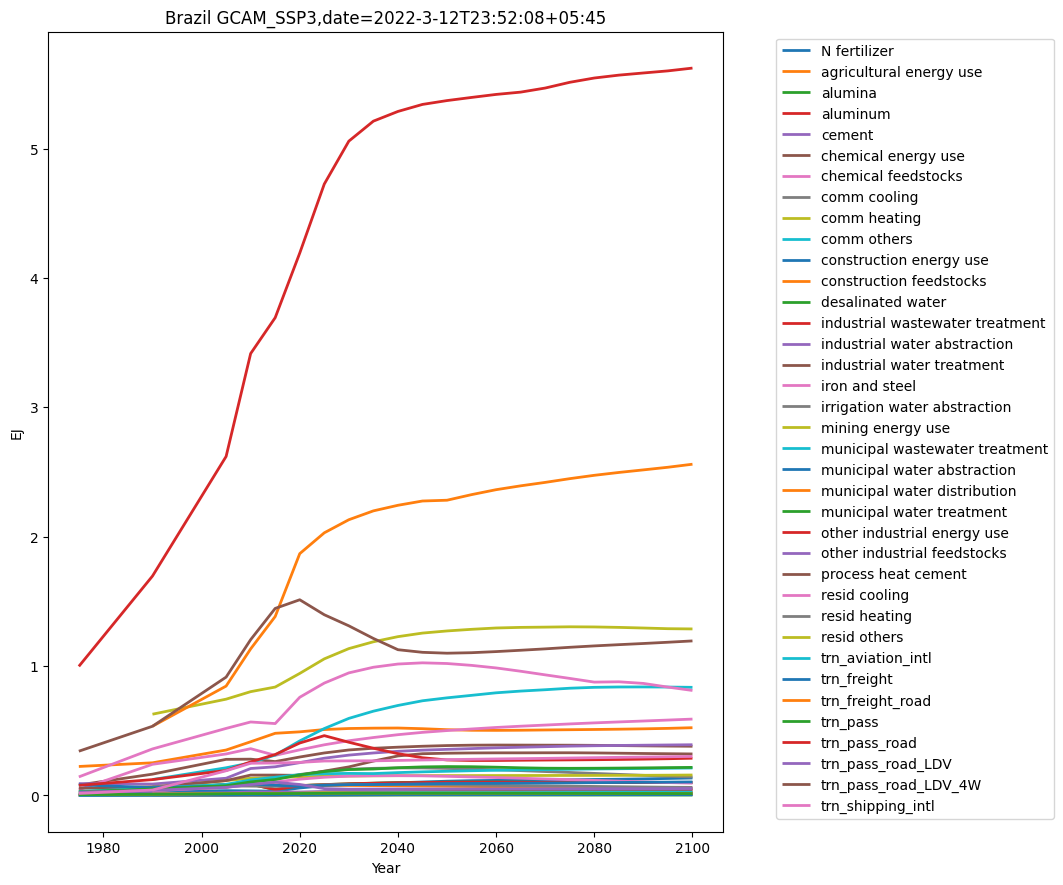

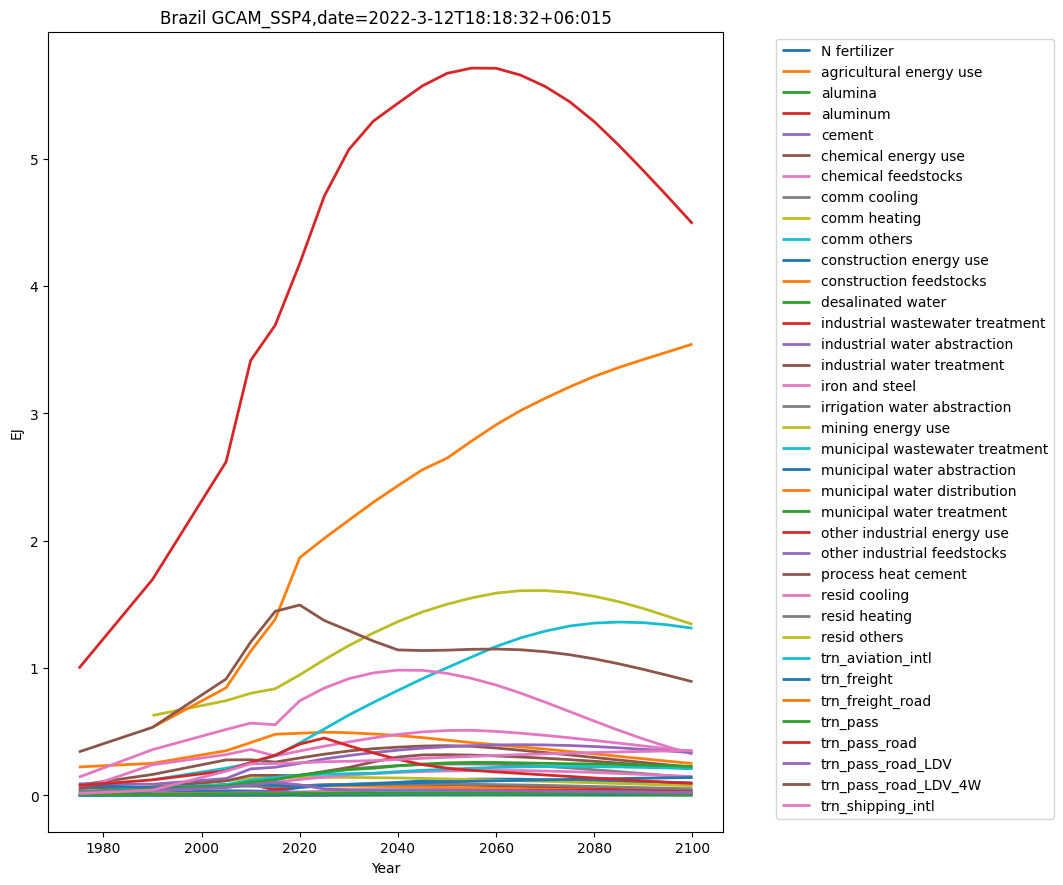

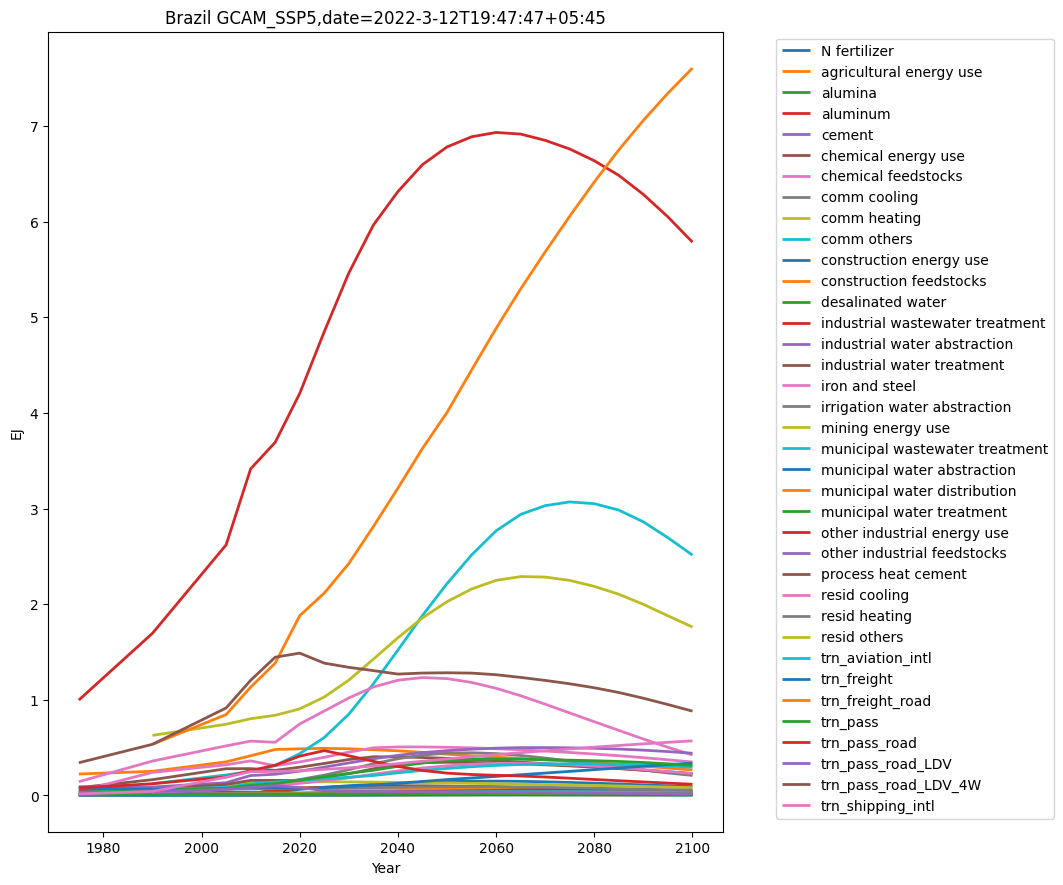

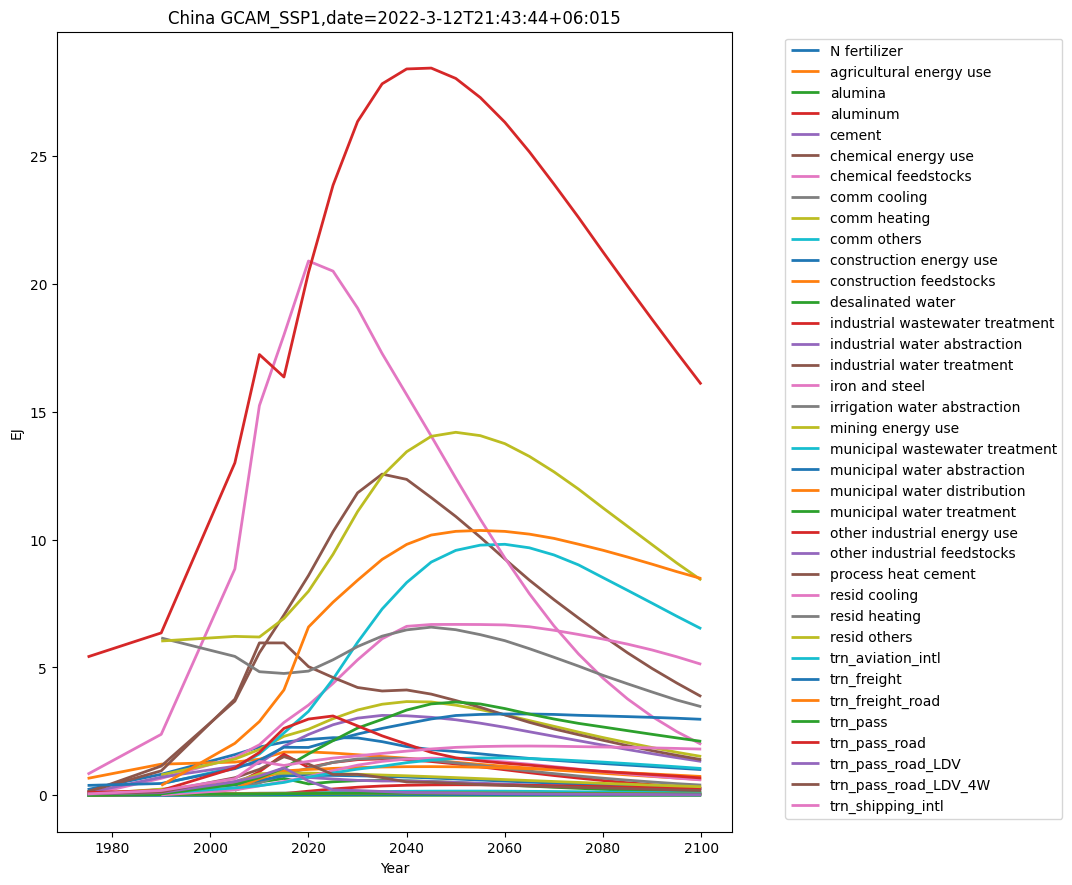

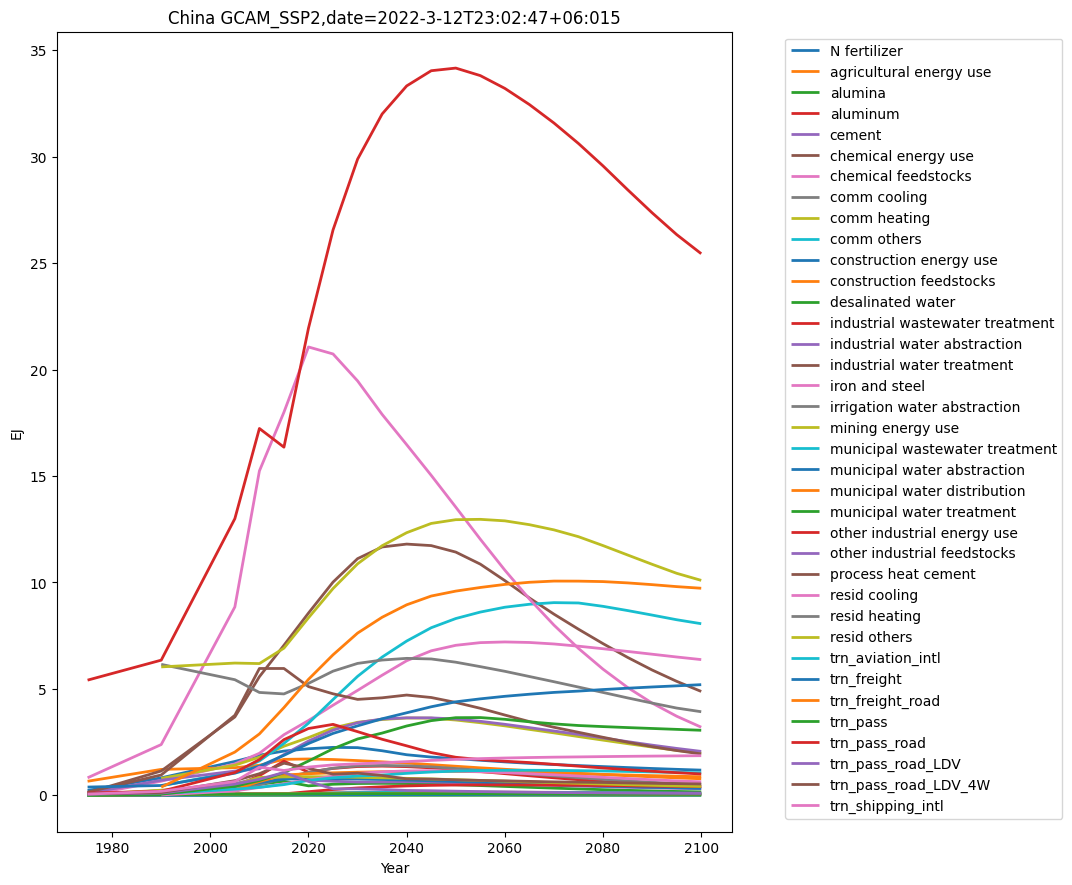

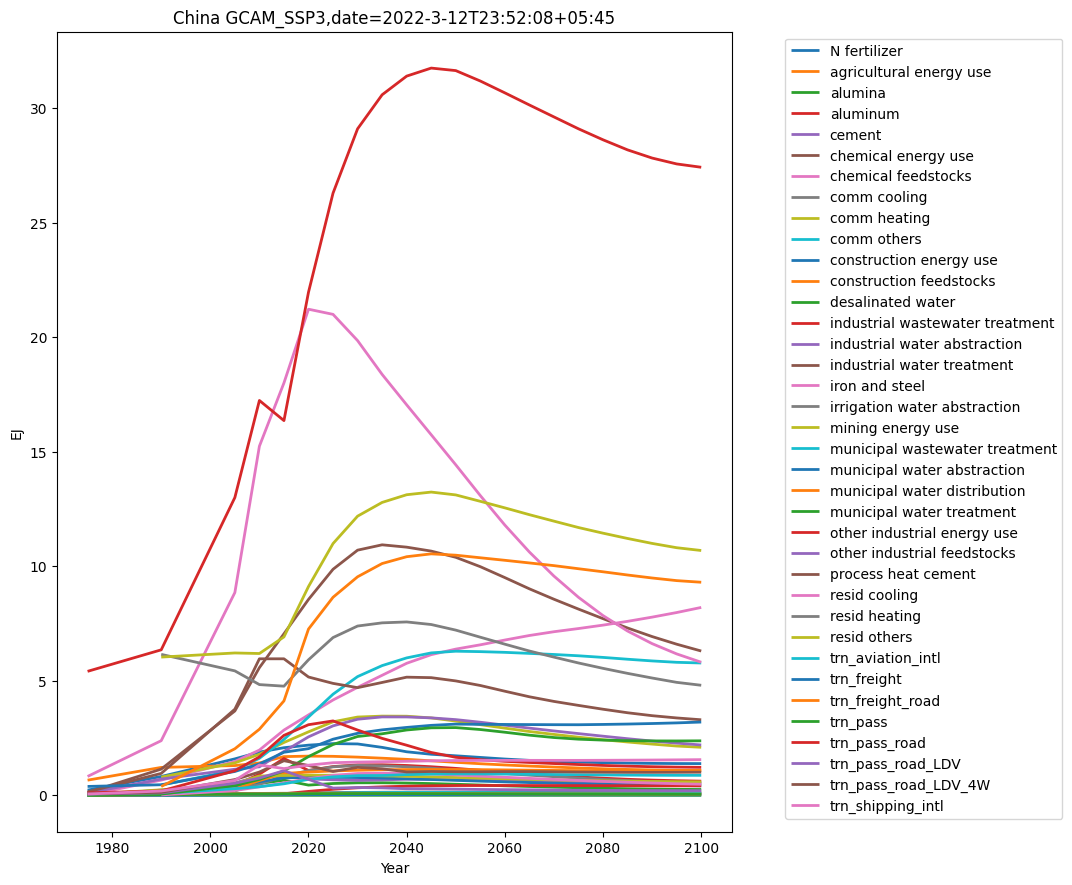

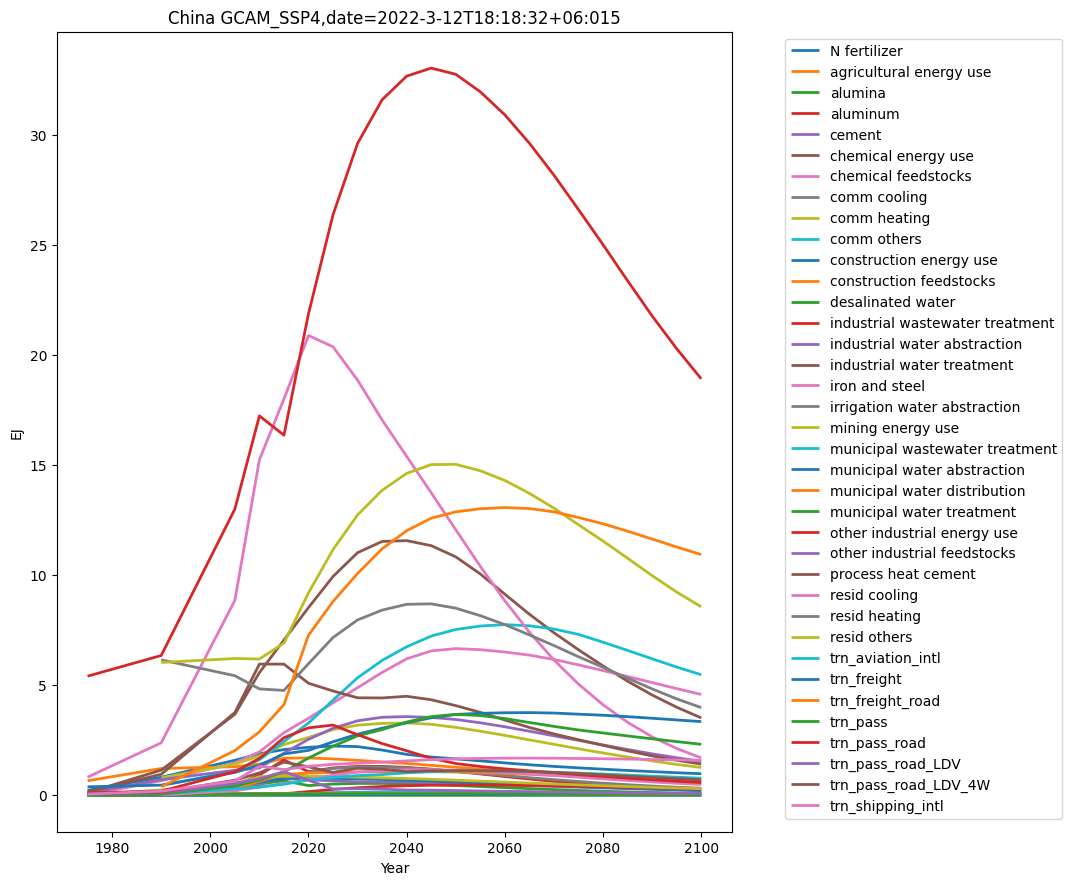

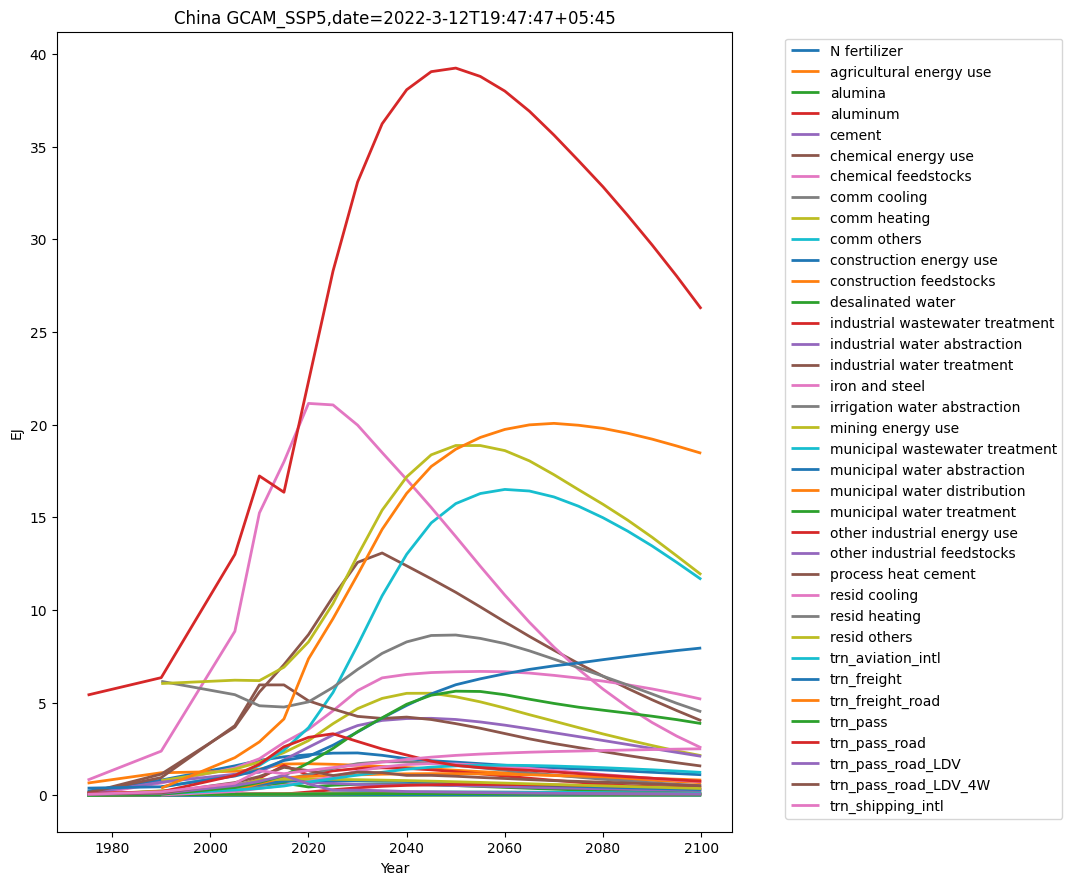

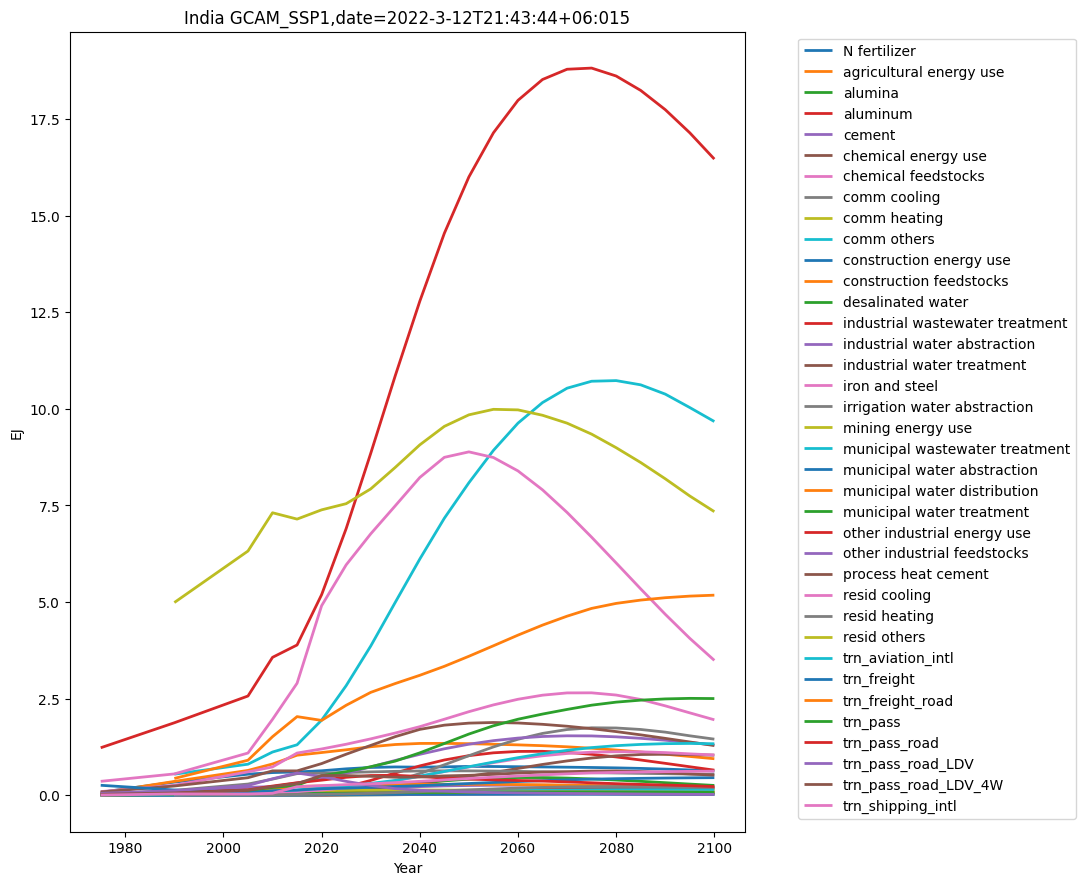

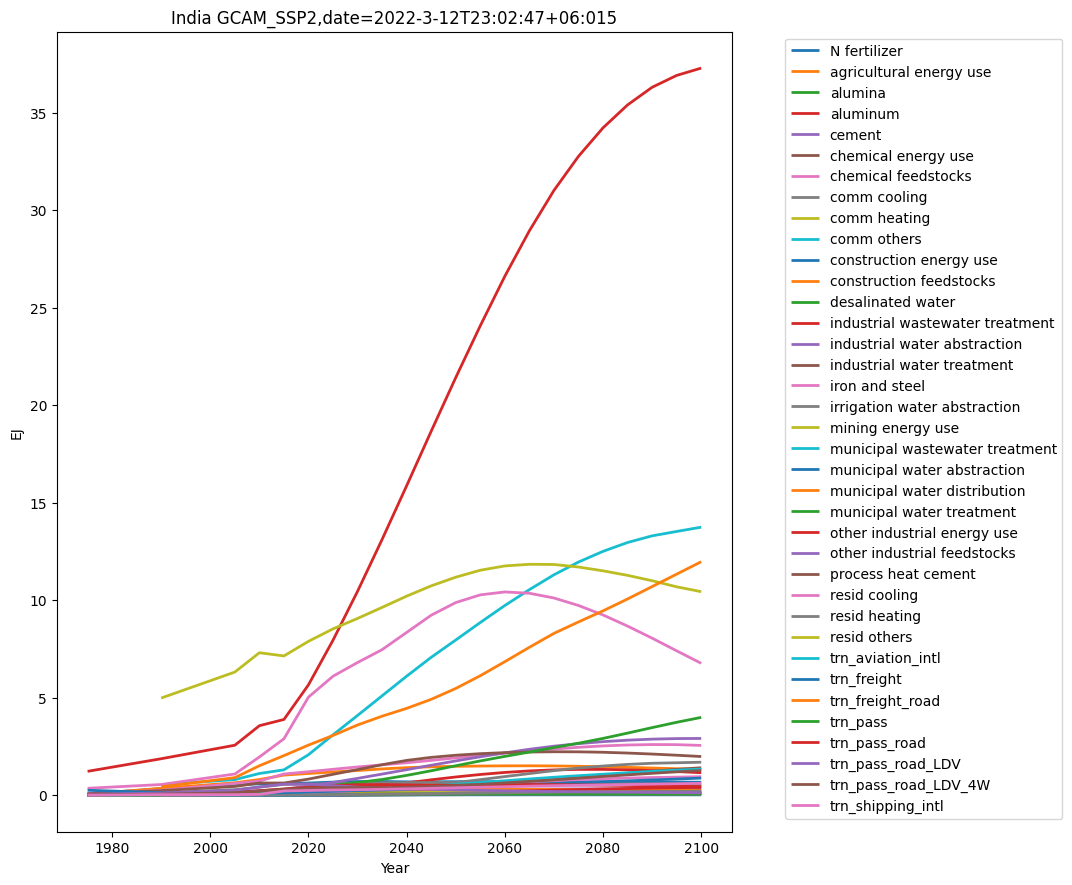

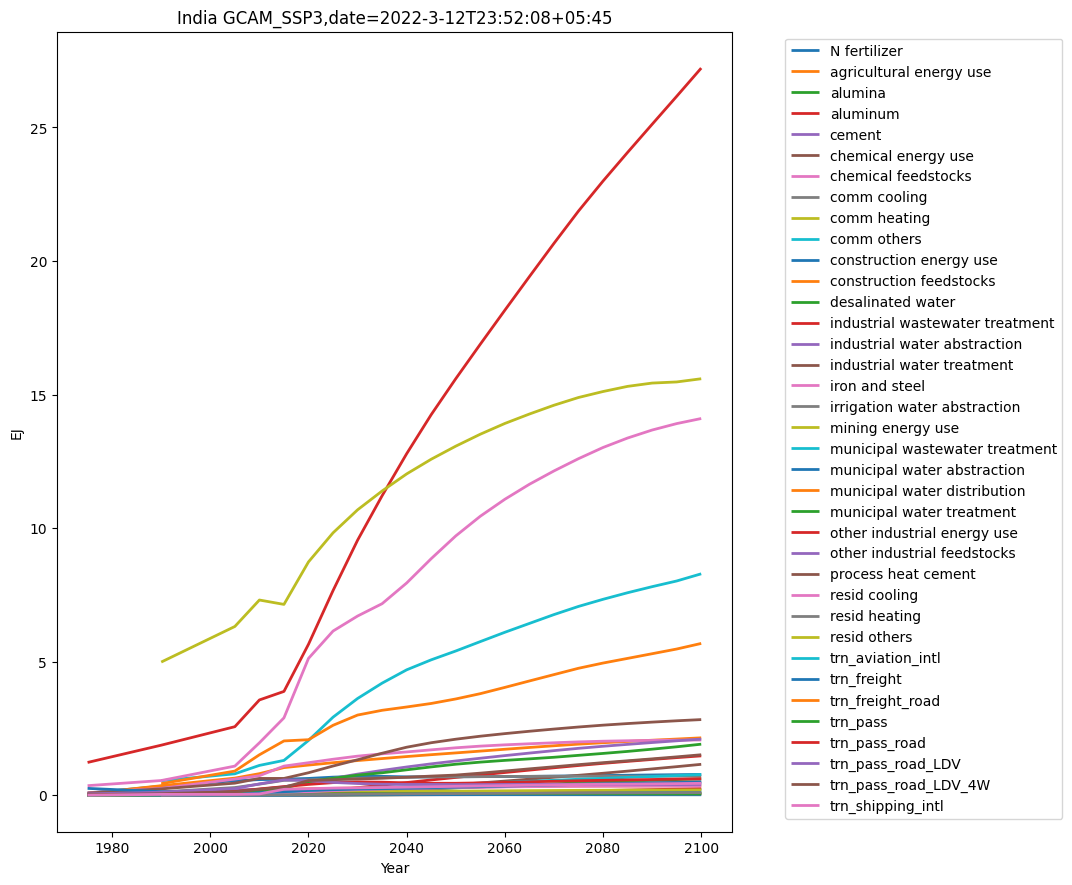

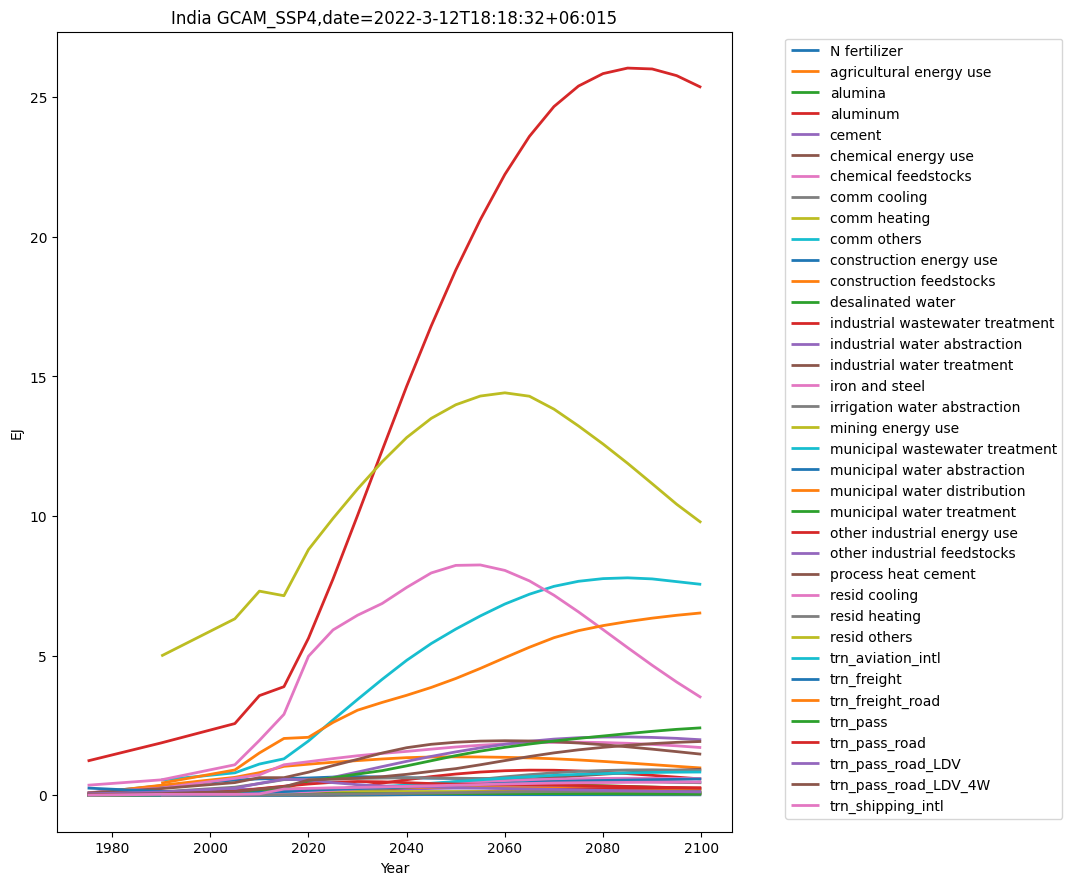

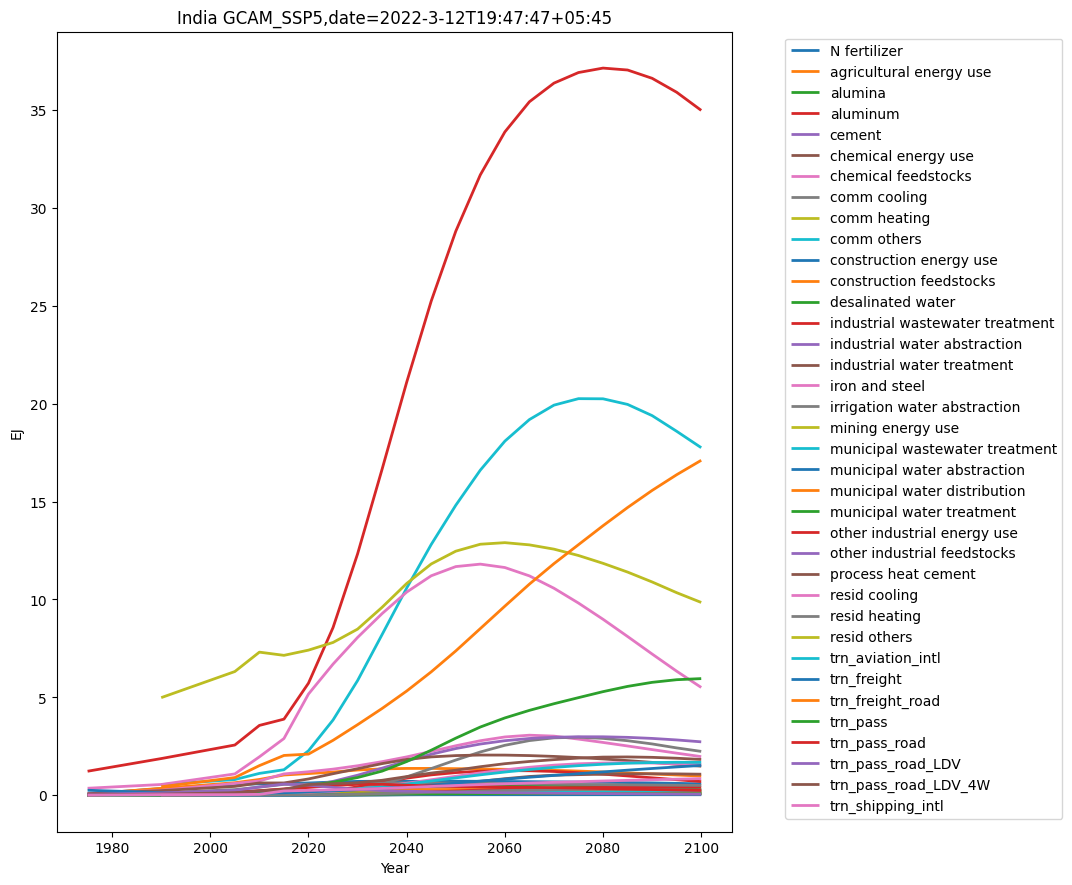

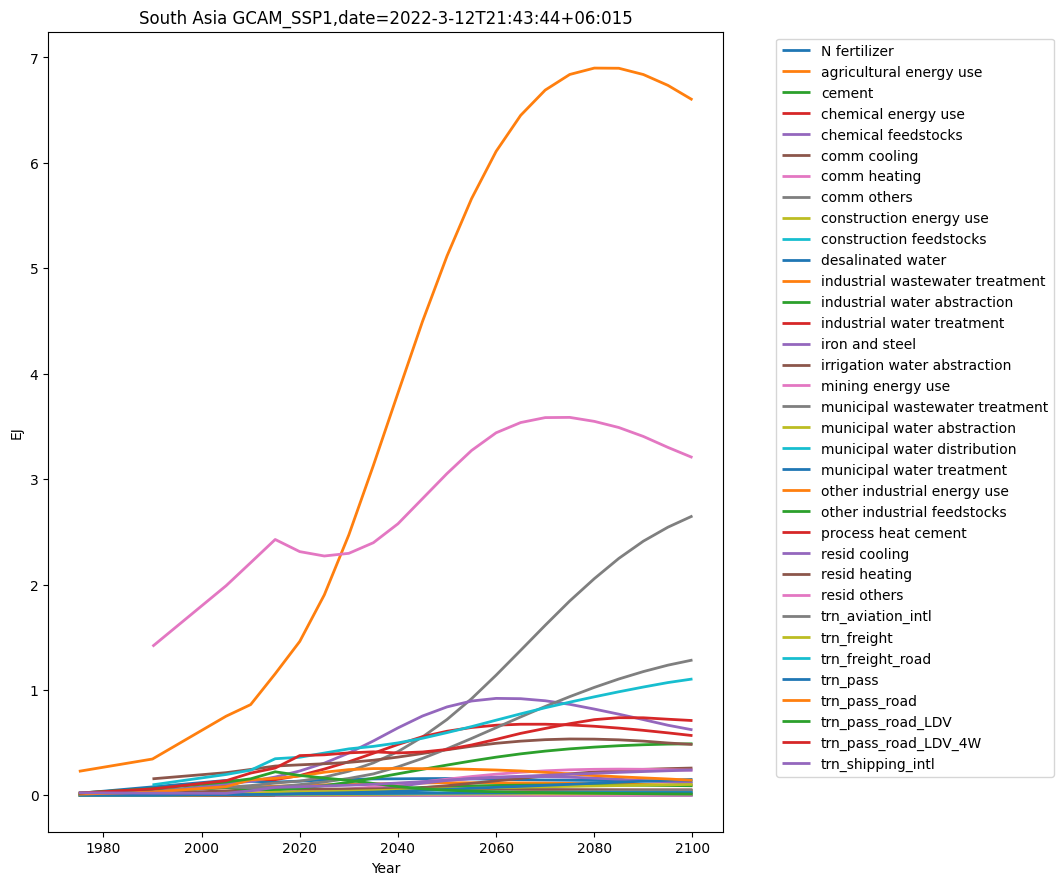

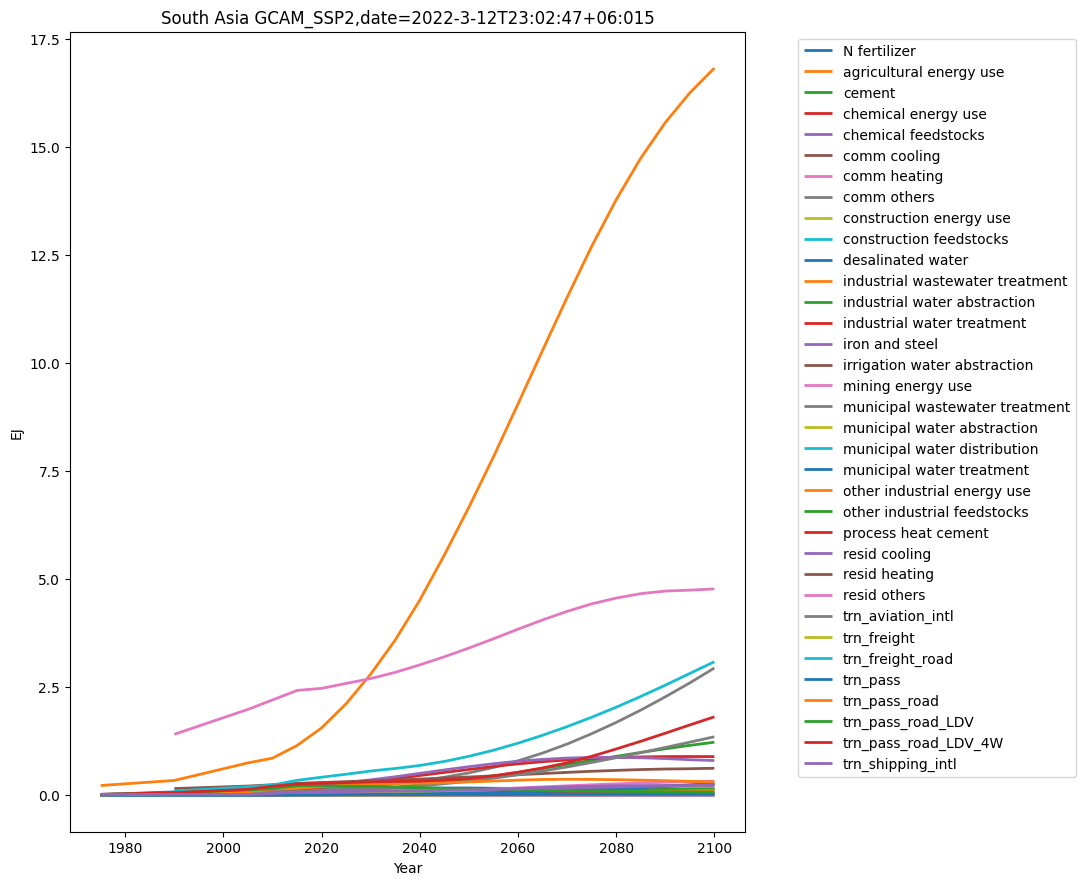

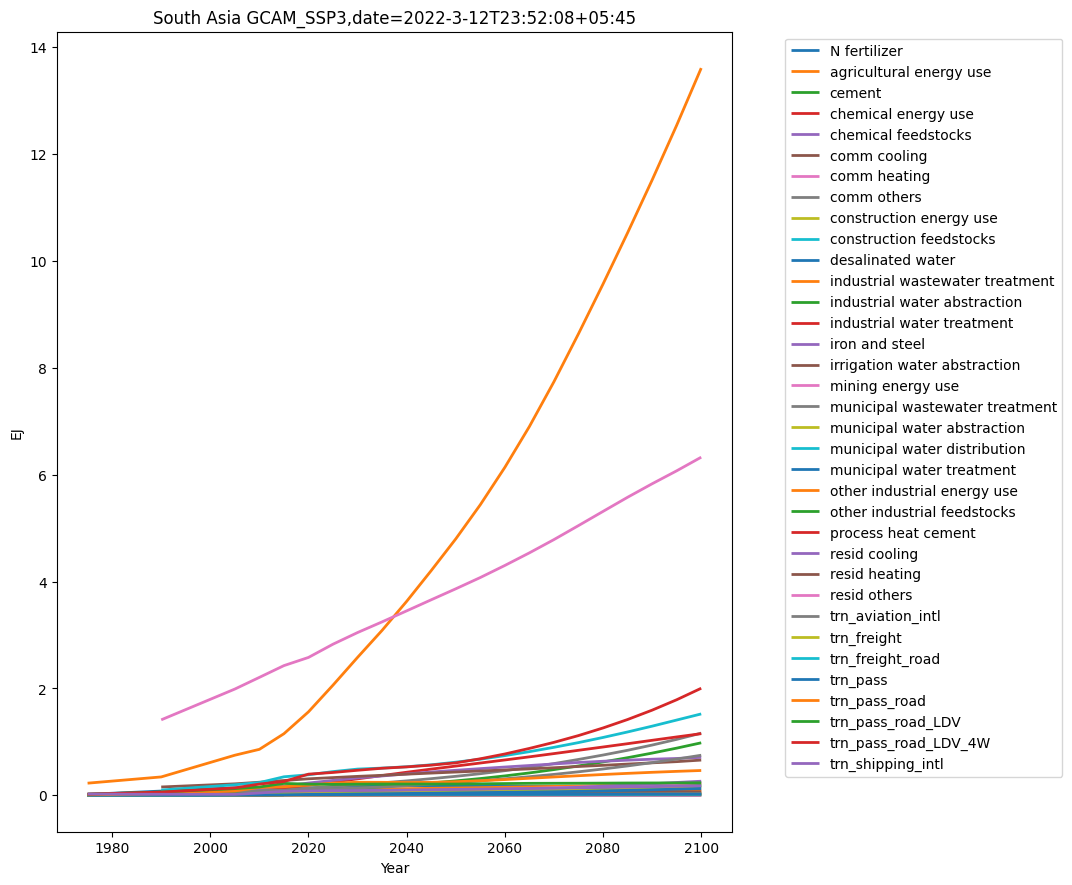

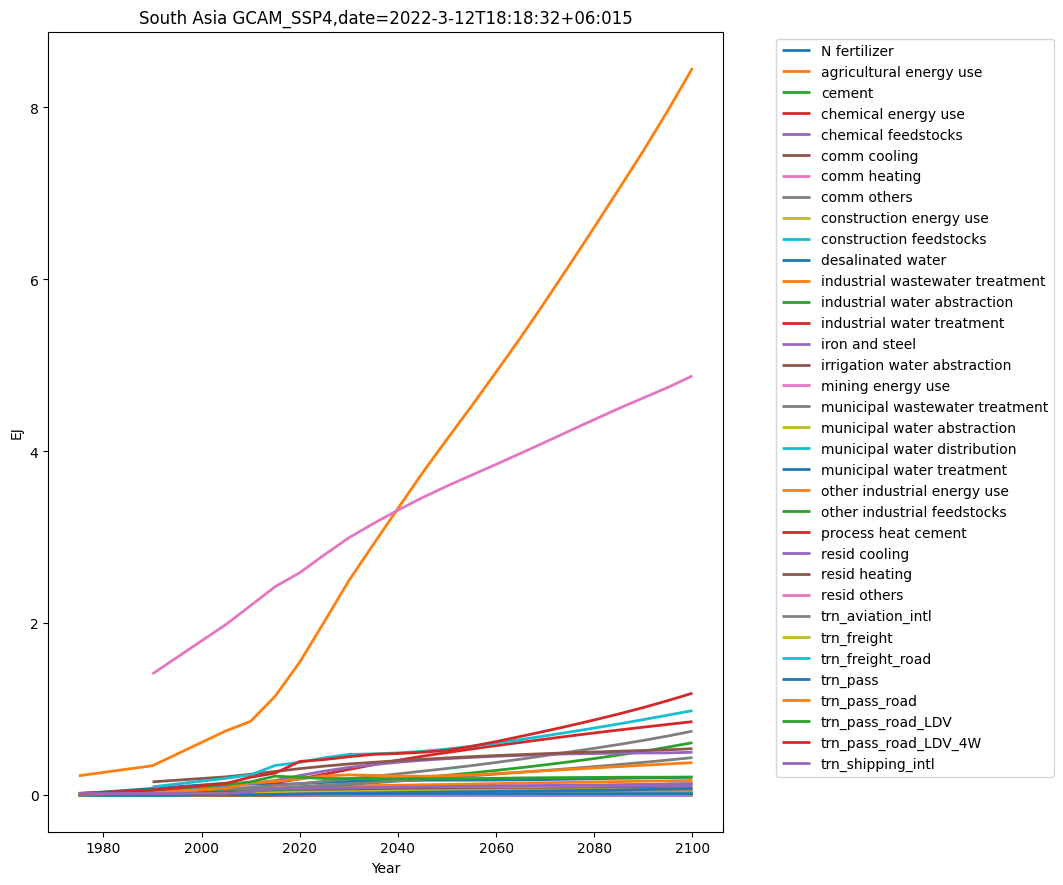

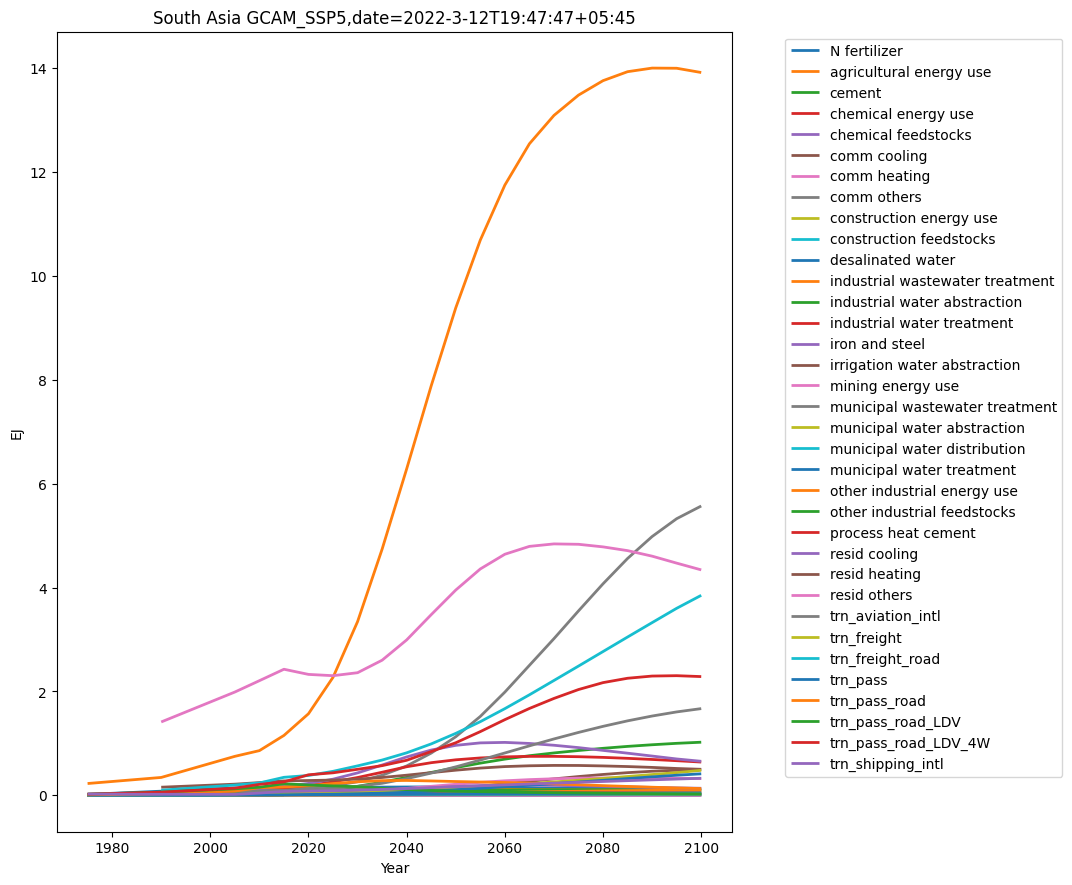

In [12]:

for region_idx in range(len(pd.unique(result['region']))):
    for scenario in pd.unique(result['scenario']):
        plot_query(result, scenario, category_col=category_column, region_idx=region_idx)